In [14]:
# 0.1 Imports & basic config
import os
from pathlib import Path
import random
import json

import torch
from torch import nn
from torch.utils.data import DataLoader, Subset
import torchvision.transforms as T
from torchvision.utils import make_grid

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# If you want tables:
import pandas as pd

# Your project imports (adapt to your structure)
import sys
sys.path.append(".")  # or "." if you're already in repo root

from src.model.unet import FMUNetCOCO
from src.fm.trainer import ImageCFMTrainerLight  # adapt if name differs
# If you have dataset/loaders:
# from src.datasets.loaders import make_loaders_coco_text_distributed

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

COCO_ROOT = Path("data/coco2017")
IMG_DIR   = COCO_ROOT / "train2017"   # or val2017 for analysis
#IMG_DIR   = COCO_ROOT / "val2017"   # or val2017 for analysis
ANN_INST  = COCO_ROOT / "annotations" / "instances_train2017.json"
ANN_CAPT  = COCO_ROOT / "annotations" / "captions_train2017.json"

'''
COCOF_ROOT = Path("/data/coco2017_5cls")
IMG_DIR   = COCOF_ROOT / "train2017"   # or val2017 for analysis
IMG_DIR   = COCOF_ROOT / "val2017"   # or val2017 for analysis
ANN_INST  = COCOF_ROOT / "annotations" / "instances_train2017.json"
ANN_CAPT  = COCOF_ROOT / "annotations" / "captions_train2017.json"
'''


CKPT_PATH = Path("runs/fm_coco_s128_b16_e100/model.pth")  # adjust
IMG_SIZE  = 128   # whatever you used for training


In [29]:
VIS_SIZE = 128  # or use IMG_SIZE if you prefer

vis_transform = T.Compose([
    T.Resize(VIS_SIZE),
    T.CenterCrop(VIS_SIZE),
    T.ToTensor(),          # stays in [0,1], nice for plotting
])


# 1) COCO DATASET

## All images

### Majority Class JSON

In [31]:
with open("/home/rsandoval/repo/sketch2image/sketch_cond/data/coco2017/cache/most_present_class_index_train.json", "r") as f:
    mc_existing_raw = json.load(f)

# JSON keys come as strings; keep them as str for comparison
mc_existing = {str(k): v for k, v in mc_existing_raw.items()}

print("Number of entries in existing index:", len(mc_existing))
# Show a small sample
sample_items = list(mc_existing.items())[:10]
sample_items


Number of entries in existing index: 35361


[('200365', 'bicycle'),
 ('495357', 'person'),
 ('116061', 'motorcycle'),
 ('514915', 'dog'),
 ('154589', 'refrigerator'),
 ('471175', 'dog'),
 ('225919', 'bicycle'),
 ('194306', 'car'),
 ('383780', 'dog'),
 ('580255', 'dog')]

### Recompute most common live

In [33]:
# 1.1 — recompute majority class per image (by NAME)
from pathlib import Path
import json

ANN_INST = Path("/home/rsandoval/repo/sketch2image/sketch_cond/data/coco2017/annotations/instances_train2017.json")

with open(ANN_INST, "r") as f:
    inst_ann = json.load(f)

# Map category_id → name
id2name = {c["id"]: c["name"] for c in inst_ann["categories"]}

# Count category frequencies per image
count_per_image = {}
for ann in inst_ann["annotations"]:
    iid = ann["image_id"]
    cid = ann["category_id"]
    count_per_image.setdefault(iid, {}).setdefault(cid, 0)
    count_per_image[iid][cid] += 1

# Take majority and convert to category name
mc_by_name = {}
for iid, counts in count_per_image.items():
    majority_cid = max(counts.items(), key=lambda x: x[1])[0]
    mc_by_name[str(iid)] = id2name[majority_cid]

print("Total images with labels:", len(mc_by_name))
# peek a few
list(mc_by_name.items())[:10]

Total images with labels: 117266


[('558840', 'bottle'),
 ('200365', 'hot dog'),
 ('495357', 'person'),
 ('116061', 'person'),
 ('16164', 'dog'),
 ('205350', 'sink'),
 ('74', 'person'),
 ('212545', 'person'),
 ('514915', 'bowl'),
 ('154589', 'knife')]

### Compare

In [34]:
keys_existing = set(mc_existing.keys())
keys_new      = set(mc_by_name.keys())
common_keys   = keys_existing & keys_new

print("Existing keys:", len(keys_existing))
print("New keys:", len(keys_new))
print("Common keys:", len(common_keys))

matches_name = 0
mismatches_name = []

for iid in common_keys:
    old = mc_existing.get(iid)   # from your JSON
    new = mc_by_name.get(iid)    # recomputed
    if old == new:
        matches_name += 1
    else:
        mismatches_name.append((iid, old, new))

print(f"Matches (by name): {matches_name}")
print(f"Mismatches (by name): {len(mismatches_name)}")

# Peek at some mismatches
mismatches_name[:20]

Existing keys: 35361
New keys: 117266
Common keys: 35361
Matches (by name): 21249
Mismatches (by name): 14112


[('18475', 'person', 'couch'),
 ('357428', 'bus', 'person'),
 ('202723', 'truck', 'person'),
 ('332159', 'sink', 'cat'),
 ('572075', 'toilet', 'cat'),
 ('387595', 'truck', 'car'),
 ('484110', 'bus', 'person'),
 ('157635', 'couch', 'book'),
 ('74544', 'parking meter', 'truck'),
 ('49716', 'train', 'person'),
 ('173163', 'train', 'person'),
 ('120320', 'person', 'bottle'),
 ('417818', 'person', 'car'),
 ('67027', 'pizza', 'carrot'),
 ('423837', 'airplane', 'car'),
 ('239466', 'person', 'skateboard'),
 ('111606', 'bowl', 'carrot'),
 ('23544', 'bed', 'bird'),
 ('35966', 'truck', 'person'),
 ('382022', 'bed', 'chair')]

## Samples

### Whats an image

In [35]:
img_info = {im["id"]: im for im in inst_ann["images"]}

def get_img_path(image_id):
    info = img_info[image_id]
    return IMG_DIR / info["file_name"]

# sanity check
some_iid = next(iter(img_info))
img_info[some_iid], get_img_path(some_iid)


({'license': 3,
  'file_name': '000000391895.jpg',
  'coco_url': 'http://images.cocodataset.org/train2017/000000391895.jpg',
  'height': 360,
  'width': 640,
  'date_captured': '2013-11-14 11:18:45',
  'flickr_url': 'http://farm9.staticflickr.com/8186/8119368305_4e622c8349_z.jpg',
  'id': 391895},
 PosixPath('data/coco2017/train2017/000000391895.jpg'))

### Show

In [36]:
from collections import defaultdict

# 4.1 Map image_id -> image info (width, height, file_name, etc.)
# inst_ann comes from the recompute cell:
# with open(ANN_INST, "r") as f: inst_ann = json.load(f)

img_info = {im["id"]: im for im in inst_ann["images"]}
print("Total images in instances file:", len(img_info))

def get_img_path(iid_str, img_dir=IMG_DIR):
    """
    iid_str: image_id as string (like in mc_existing / mc_by_name)
    img_dir: root directory with train2017 images (from your setup)
    """
    iid = int(iid_str)
    info = img_info.get(iid, None)
    if info is None:
        raise KeyError(f"image_id {iid} not found in img_info")
    return img_dir / info["file_name"]

# quick sanity check
some_iid_str = next(iter(mc_existing.keys()))
print("Example image_id:", some_iid_str)
print("Resolved path:", get_img_path(some_iid_str))

# 4.2 Build class_name -> list[image_id] using YOUR existing index
class_to_iids = defaultdict(list)
for iid_str, cls in mc_existing.items():   # or mc_by_name if you prefer
    class_to_iids[cls].append(iid_str)

print("Number of classes:", len(class_to_iids))
list(list(class_to_iids.items())[:10])  # peek at a few classes


Total images in instances file: 118287
Example image_id: 200365
Resolved path: data/coco2017/train2017/000000200365.jpg
Number of classes: 78


[('bicycle',
  ['200365',
   '225919',
   '369190',
   '233660',
   '79966',
   '392659',
   '49097',
   '386968',
   '82312',
   '326911',
   '316694',
   '459141',
   '317715',
   '446409',
   '458119',
   '171753',
   '20307',
   '171809',
   '536321',
   '111970',
   '257036',
   '94536',
   '251639',
   '72810',
   '327529',
   '118450',
   '541897',
   '390298',
   '412151',
   '70744',
   '86135',
   '17882',
   '507249',
   '555622',
   '453481',
   '225784',
   '203564',
   '509822',
   '323564',
   '337011',
   '334140',
   '317320',
   '162763',
   '292819',
   '440284',
   '294918',
   '520427',
   '416098',
   '561928',
   '255232',
   '330098',
   '122302',
   '189772',
   '234533',
   '86448',
   '565374',
   '251124',
   '521197',
   '493846',
   '453138',
   '522262',
   '250794',
   '526622',
   '429924',
   '20342',
   '127788',
   '456695',
   '480036',
   '435745',
   '398304',
   '262228',
   '148668',
   '133680',
   '238147',
   '249815',
   '245642',
   '6019',

Class 'person': 4708 images in index


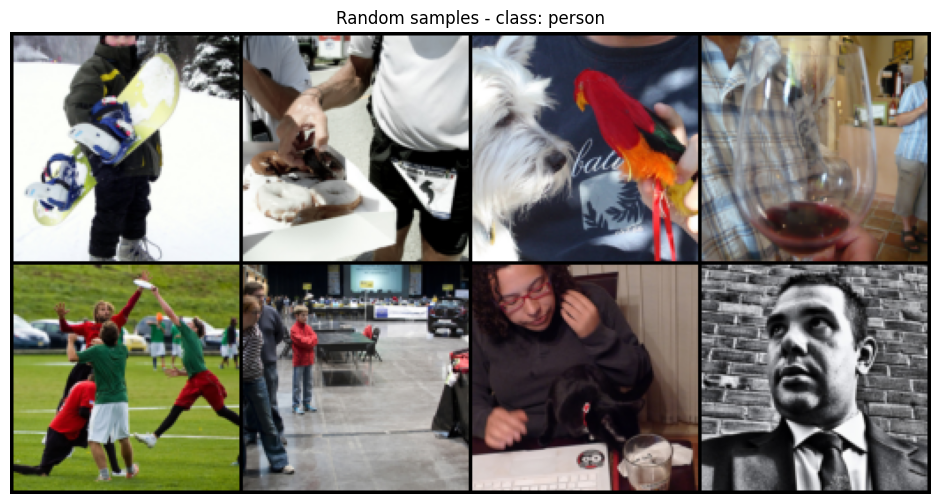

Class 'dog': 830 images in index


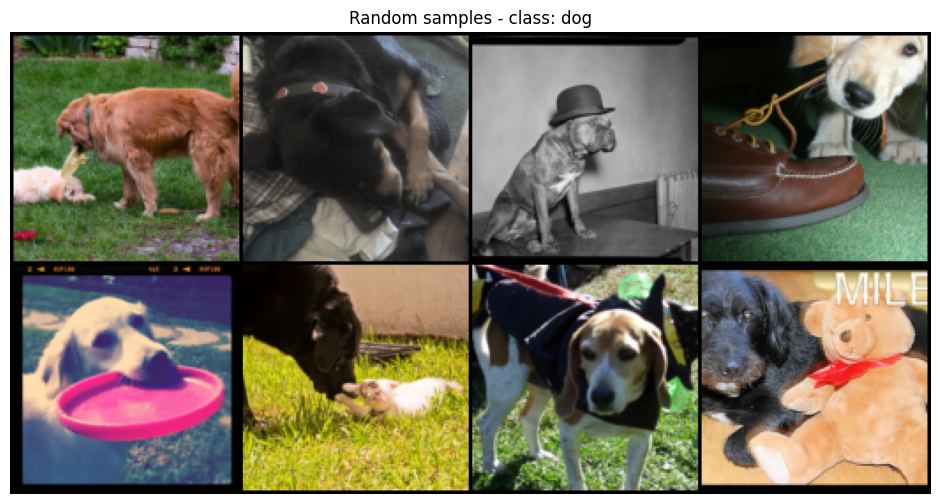

Class 'bicycle': 296 images in index


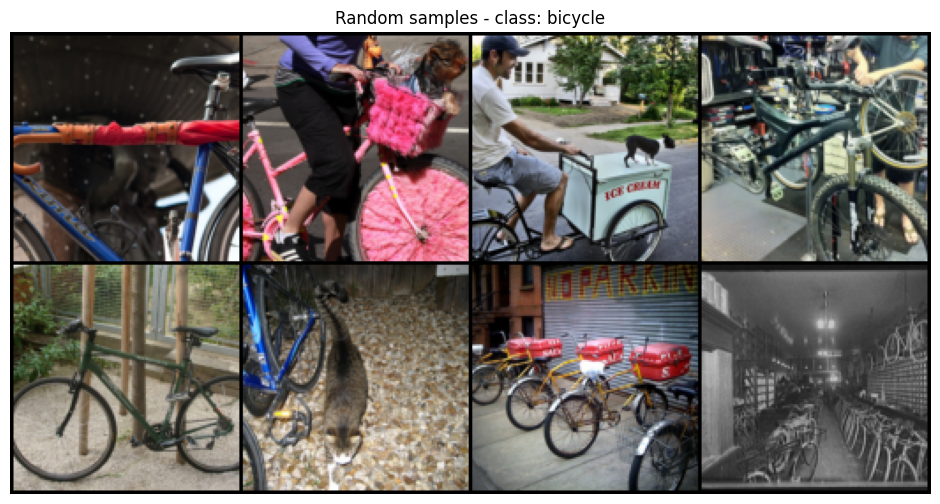

Class 'car': 711 images in index


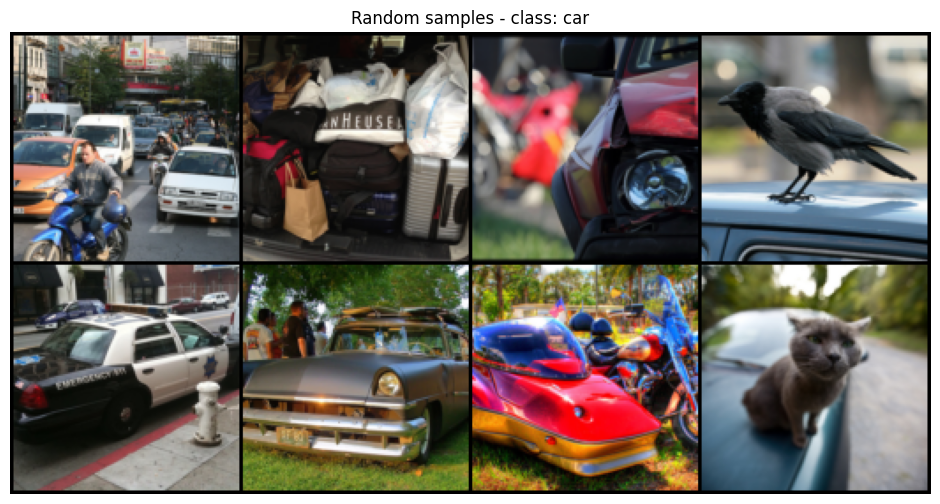

In [37]:
def show_class_grid(class_name, n=8):
    """
    Show up to n random images whose majority class is `class_name`.
    Uses mc_existing + IMG_DIR, resizing them to a common size so make_grid works.
    """
    iids = class_to_iids.get(class_name, [])
    print(f"Class '{class_name}': {len(iids)} images in index")
    if not iids:
        return
    
    sample_iids = random.sample(iids, min(n, len(iids)))
    
    imgs = []
    for iid_str in sample_iids:
        path = get_img_path(iid_str)
        if not path.exists():
            print(f"[warn] File not found: {path}")
            continue

        img = Image.open(path).convert("RGB")
        img_t = vis_transform(img)   # <-- resize + center crop + ToTensor
        imgs.append(img_t)
    
    if not imgs:
        print("No images could be loaded for this class.")
        return
    
    grid = make_grid(imgs, nrow=min(4, len(imgs)))
    plt.figure(figsize=(12, 6))
    plt.imshow(grid.permute(1, 2, 0))
    plt.axis("off")
    plt.title(f"Random samples - class: {class_name}")
    plt.show()

for cls in ["person", "dog", "bicycle", "car"]:
    show_class_grid(cls)


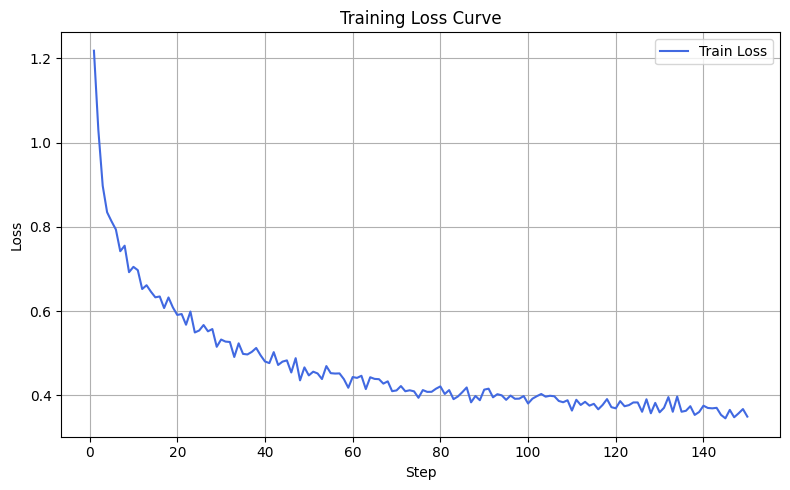

In [3]:
import json
import matplotlib.pyplot as plt

# Load JSON
with open("/home/rsandoval/repo/sketch2image/sketch_cond/runs/fm_coco_filtered_s128_b64_e150/metrics.json", "r") as f:
    data = json.load(f)

# Extract only the train data
train_losses = data["train"]

# Create an x-axis (assuming each value is one step or iteration)
steps = list(range(1, len(train_losses) + 1))

# Plot
plt.figure(figsize=(8, 5))
plt.plot(steps, train_losses, label="Train Loss", color="royalblue")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Validation losses (raw):     [8.15805376e-01 6.52254760e-01 5.02833486e-01 6.77054107e-01
 4.60679680e-01 4.63859141e-01 7.85881400e-01 4.14606929e-01
 5.14386058e-01 3.02583337e-01 1.74908531e+05 3.52632046e-01
 4.38352376e-01 4.20008332e-01 2.34631909e+03]
Clip threshold:             0.8128129780292511
Validation (after clip):    [0.81281298 0.65225476 0.50283349 0.67705411 0.46067968 0.46385914
 0.7858814  0.41460693 0.51438606 0.30258334 0.81281298 0.35263205
 0.43835238 0.42000833 0.81281298]


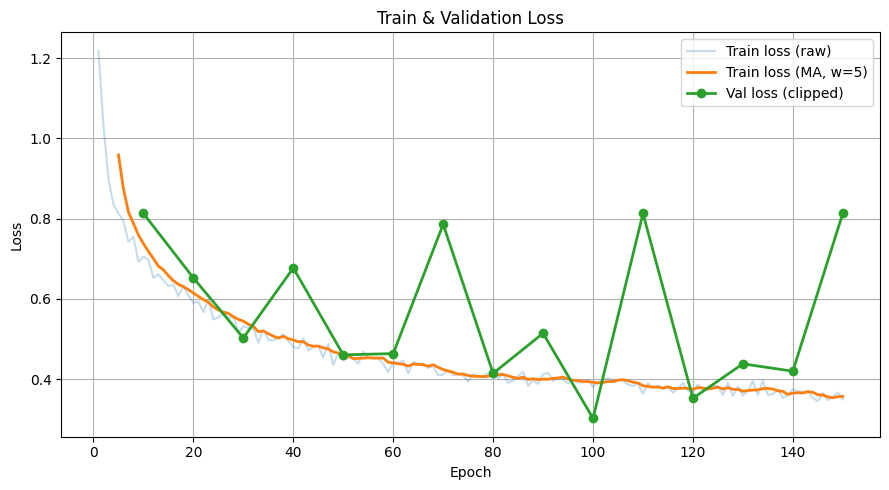

In [8]:
import json
import numpy as np
import matplotlib.pyplot as plt

# ---- 1. Load JSON ----
with open("/home/rsandoval/repo/sketch2image/sketch_cond/runs/fm_coco_filtered_s128_b64_e150/metrics.json", "r") as f:

    data = json.load(f)

# ---- 2. Train data (raw + smoothed) ----
train_losses = np.array(data["train"])
train_epochs = np.arange(1, len(train_losses) + 1)  # 1, 2, ..., N

def moving_average(x, window=5):
    x = np.asarray(x)
    return np.convolve(x, np.ones(window) / window, mode="valid")

window = 5
train_ma = moving_average(train_losses, window=window)
train_ma_epochs = train_epochs[window - 1:]  # align x with the shorter MA array

# ---- 3. Validation data + outlier clipping ----
val_epochs = np.array([d["epoch"] for d in data["val"]])
val_losses_raw = np.array([d["loss"] for d in data["val"]])

# Clip extreme outliers (e.g. above 90th percentile)
clip_threshold = np.percentile(val_losses_raw, 85)
val_losses_clipped = np.clip(val_losses_raw, None, clip_threshold)

print("Validation losses (raw):    ", val_losses_raw)
print("Clip threshold:            ", clip_threshold)
print("Validation (after clip):   ", val_losses_clipped)

# ---- 4. Plot everything ----
plt.figure(figsize=(9, 5))

# Raw train loss (faint)
plt.plot(train_epochs, train_losses, alpha=0.25, label="Train loss (raw)")

# Smoothed train loss
plt.plot(train_ma_epochs, train_ma, linewidth=2, label=f"Train loss (MA, w={window})")

# Validation loss (clipped)
plt.plot(val_epochs, val_losses_clipped, "o-", linewidth=2, label="Val loss (clipped)")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train & Validation Loss")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
